# Project: Traffic Sign Recognition Classifier

In this project, I use convolutional neural network to classify traffic signs. Specifically, I train a model to classify traffic signs from the German Traffic Sign [Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).
There are lots of different neural networks frameworks available. I used TensorFlow as I already had some experience with it. The model was trained on GPU. The TensorFlow instructions for installing TensorFlow with GPU support you can find [here](https://www.tensorflow.org/install/#optional_install_cuda_gpus_on_linux).

---
## Step 1: Load The Data
To download Datased please [click](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip). This is a pickled dataset resized to 32x32.

In [ ]:
# Load pickled data
import pickle

# Training, validation and testing data are saved on this files
training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

In [2]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np

# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples.
n_valid = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory dataset visualization

Visualize the German Traffic Signs Dataset using the pickled file(s). Plotting random traffic sign images and its count.

Train observation #: 28188    label: 12


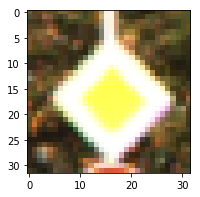

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import random

index = random.randint(0, n_train)
image = X_train[index]

plt.figure(figsize=(3,3))
plt.imshow(image)
print("Train observation #: {}    label: {}".format(index, y_train[index]))

Trafic signs summary statistics:
count      43.0
mean      809.0
std       627.0
min       180.0
50%       540.0
max      2010.0
Name: Trafic Signs, dtype: float64


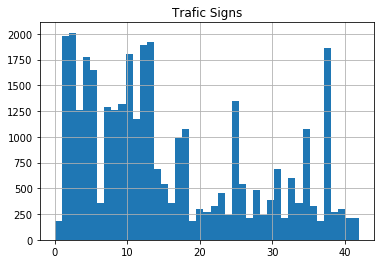

In [5]:
import pandas as pd
d = pd.DataFrame(y_train, columns=['Trafic Signs'])
#d.hist()
grouped = d.groupby(['Trafic Signs'])['Trafic Signs'].count()
d.hist(bins=43)
print('Trafic signs summary statistics:\n{}'.format(round(grouped.describe(percentiles=[]),0)))

----

## Step 2: Design and Test a Model Architecture

Design and implementation of a deep learning model to recognize traffic signs.

The LeNet-5 implementation shown as a solid starting point. I have changed the number of classes and preprocessing steps, but aside from that it's plug and play!

With the LeNet-5 solution I got a validation set accuracy of 0.946 and a test set accuracy of 0.942.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Ppreprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others)
- Data augmentation - to generate fake data

### Pre-process the Data Set (normalization, grayscale, etc.)

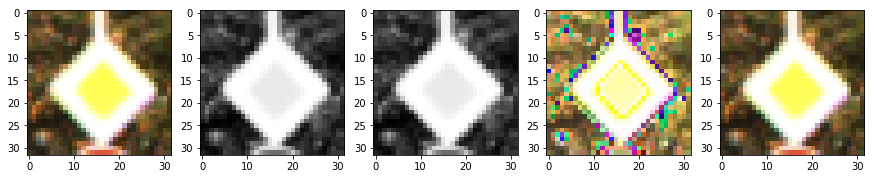

In [6]:
import cv2

def preProc1(image, kernel_size = 1):
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #image = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
    return image

def preProc2(image):
    return ((image - 128.0)/128.0)

def preProc3(image):
    return image / 255.0


example1 = image.squeeze()
example2 = preProc2(preProc1(image)).squeeze()
example3 = preProc3(preProc1(image)).squeeze()
example4 = preProc2(image).squeeze()
example5 = preProc3(image).squeeze()

# Three subplots sharing both x/y axes

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15,3))
ax1.imshow(example1)
ax2.imshow(example2, cmap='gray')
ax3.imshow(example3, cmap='gray')
ax4.imshow(example4)
ax5.imshow(example5)

I tried different preprocessing and finally choose preProc1()

(32, 32)

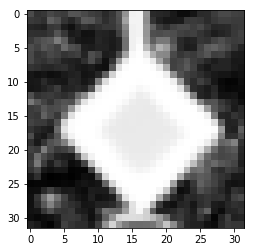

In [7]:
# Apply preprocessin on all features
X_train_p = np.array([preProc3(preProc1(x)).reshape((32,32,1)) for x in X_train])
X_valid_p = np.array([preProc3(preProc1(x)).reshape((32,32,1)) for x in X_valid])
X_test_p  = np.array([preProc3(preProc1(x)).reshape((32,32,1)) for x in X_test])

#X_train_p = np.array([preProc2((x)) for x in X_train])
#X_valid_p = np.array([preProc2((x)) for x in X_valid])
#X_test_p  = np.array([preProc2((x)) for x in X_test])

#X_train_p = X_train
#X_valid_p = X_valid
#X_test_p  = X_test

example = X_train_p[index].squeeze()
plt.imshow(example, cmap='gray')
example.shape

In [8]:
# Apply preprocessin on all labels
from sklearn.preprocessing import OneHotEncoder

y_train_o = y_train.reshape((y_train.shape[0],1))
y_valid_o = y_valid.reshape((y_valid.shape[0],1))
y_test_o  = y_test.reshape( (y_test.shape[0],1) )

one = OneHotEncoder()
one.fit(y_train_o)
y_train_o = one.transform(y_train_o).toarray()
y_valid_o = one.transform(y_valid_o).toarray()
y_test_o  = one.transform(y_test_o ).toarray()

In [9]:
# Shuffle training data
from sklearn.utils import shuffle

X_train_p, y_train_o = shuffle(X_train_p, y_train_o)

### Model Architecture

In [10]:
# The EPOCH and BATCH_SIZE values affect the training speed and model accuracy.

import tensorflow as tf

EPOCHS = 35
BATCH_SIZE = 128

In [11]:
### Model architecture.

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x10.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 10), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(10))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x10. Output = 15x15x10.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 12x12x30.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(4, 4, 10, 30), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(30))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 12x12x30. Output = 6x6x30.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten. Input = 6x6x30. Output = 1080.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1080. Output = 270.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1080, 270), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(270))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 270. Output = 129.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(270, 129), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(129))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 129. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(129, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
### Train the model.

# x is a placeholder for a batch of input images. one_hot_y is a placeholder for a batch of output labels .
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None,43))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

In [13]:
# A training pipeline that uses the model to classify data.
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [14]:
# Evaluate how well the loss and accuracy of the model for a given dataset.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Here you can the following steps:

* Run the training data through the training pipeline to train the model.
* Shuffle the training set before each epoch
* After each epoch, measure the loss and accuracy of the validation set.
* Save the model after training.

In [15]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_p, y_train_o = shuffle(X_train_p, y_train_o)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_p[offset:end], y_train_o[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid_p, y_valid_o)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.711

EPOCH 2 ...
Validation Accuracy = 0.848

EPOCH 3 ...
Validation Accuracy = 0.894

EPOCH 4 ...
Validation Accuracy = 0.896

EPOCH 5 ...
Validation Accuracy = 0.916

EPOCH 6 ...
Validation Accuracy = 0.899

EPOCH 7 ...
Validation Accuracy = 0.917

EPOCH 8 ...
Validation Accuracy = 0.921

EPOCH 9 ...
Validation Accuracy = 0.929

EPOCH 10 ...
Validation Accuracy = 0.929

EPOCH 11 ...
Validation Accuracy = 0.932

EPOCH 12 ...
Validation Accuracy = 0.935

EPOCH 13 ...
Validation Accuracy = 0.929

EPOCH 14 ...
Validation Accuracy = 0.937

EPOCH 15 ...
Validation Accuracy = 0.935

EPOCH 16 ...
Validation Accuracy = 0.948

EPOCH 17 ...
Validation Accuracy = 0.936

EPOCH 18 ...
Validation Accuracy = 0.946

EPOCH 19 ...
Validation Accuracy = 0.934

EPOCH 20 ...
Validation Accuracy = 0.943

EPOCH 21 ...
Validation Accuracy = 0.946

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

In [16]:
# model performance evaluation On the test set.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_p, y_test_o)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.942


---

## Step 3: Test a Model on New Images

To have more insight how model works, I downloaded at several pictures of German traffic signs from the web and used the model to predict the traffic sign type.

File `signnames.csv` contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
# helper function for image downloading

from PIL import Image
import requests

def download_image(url):
    im = Image.open(requests.get(url, stream=True).raw)
    return np.array(im)

In [18]:
# test images from the web
links = [
    'http://previews.123rf.com/images/mygrafics/mygrafics1109/mygrafics110900301/10647917-traffic-signs-Stock-Vector-speed-sign.jpg',
    'https://simonehr.files.wordpress.com/2013/11/stopsign.jpg',
    'http://bicyclegermany.com/Images/Laws/Arterial.jpg',
    'http://i.dailymail.co.uk/i/pix/2016/05/08/09/33F2DCE500000578-3579315-image-a-19_1462696012816.jpg',
    'https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Australian_60kmh_speed_limit_sign.jpg/800px-Australian_60kmh_speed_limit_sign.jpg'
]
all_5 = [download_image(link) for link in links]
all_5_reshape = [im.reshape([1] + list(im.shape)) for im in all_5]

In [19]:
# resize images
with tf.Session() as sess:
    output = [sess.run(tf.image.resize_nearest_neighbor(images = im, size = (32, 32))) for im in all_5_reshape]

Here you can see downloaded pictures:

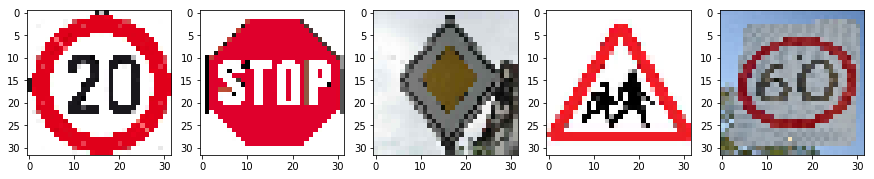

In [20]:
f, ax = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    ax[i].imshow(output[i][0])

Apply preprocessin on 5 test images

In [ ]:
X_5 = np.array([preProc3(preProc1(output[i][0])).reshape((32,32,1)) for i in range(5)])
Labels_5 = [0, 14, 12, 28, 3]
example = X_5[1].squeeze()
plt.imshow(example, cmap='gray')
example.shape

### Predict the Sign Type for Each Image

In [22]:
def Prediction(X_data):
    sess = tf.get_default_session()
    pred = sess.run(tf.argmax(logits, 1), feed_dict={x: X_data, keep_prob: 1.0})
    return pred

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    pred = Prediction(X_5)

### Analyze Performance

In [23]:
# The accuracy for these 5 new images. 
print("Prediction accuracy on 5 images is {}%".format(np.average(pred == Labels_5)*100))

Prediction accuracy on 5 images is 100.0%


### Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images I printed out the model's softmax probabilities to show the **certainty** of the model's predictions (the output is limited up to top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Lets consider the following numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]` - the 3 largest probabilities in `a` and `[3, 0, 5]` are the corresponding indices.

In [26]:
# The top 5 softmax probabilities for the predictions on the German traffic sign images found on the web. 
predicted_labels = tf.nn.softmax(logits)

def Top_5(X_data):
    sess = tf.get_default_session()
    pred = sess.run(tf.nn.top_k(predicted_labels, k = 5), feed_dict={x: X_data, keep_prob: 1.0})
    return pred

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top = Top_5(X_5)
print('Top 5 Probabilities for the prediciton: \n\n {} \n\n Top 5 labels for the prediction: \n\n {} \n\n \
Correct labels: \n\n {}'.format(top[0].round(2), top[1], Labels_5))

Top 5 Probabilities for the prediciton: 

 [[ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 0.81999999  0.07        0.06        0.02        0.01      ]] 

 Top 5 labels for the prediction: 

 [[ 0  1 29 38  4]
 [14 13  1 38 12]
 [12 40 35 13 15]
 [28 30  3 11 29]
 [ 3  2 40 16  5]] 

 Correct labels: 

 [0, 14, 12, 28, 3]


# **Traffic Sign Recognition** 

---

**Build a Traffic Sign Recognition Project**

The goals / steps of this project are the following:
* Load the data set (see below for links to the project data set)
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Use the model to make predictions on new images
* Analyze the softmax probabilities of the new images
* Summarize the results with a written report


[//]: # (Image References)

[image1]: ./examples/stat.png "Statistics"
[image2]: ./examples/image_before.png "Image before"
[image3]: ./examples/image_after.png "Image after"
[image4]: ./examples/new_images.png  "New"
[image5]: ./examples/placeholder.png "Traffic Sign 2"
[image6]: ./examples/placeholder.png "Traffic Sign 3"
[image7]: ./examples/placeholder.png "Traffic Sign 4"
[image8]: ./examples/placeholder.png "Traffic Sign 5"

## Rubric Points

### Data Set Summary & Exploration

#### 1. A basic summary of the data set.

The code for this step is contained in the 3d code cell of the IPython notebook.  

I used the pandas library to calculate summary statistics of the traffic
signs data set:

* Number of training examples = 34799
* Number of testing examples = 12630
* Image data shape = (32, 32, 3)
* Number of classes = 43

#### 2. Exploratory visualization of the dataset.

The code for this step is contained in the 5th code cell of the IPython notebook.  

Here is an exploratory visualization of the data set. It is a bar chart showing how the data is distributed. We see that the distribution is uneven.

![alt text][image1]

Trafic signs summary statistics:
count      43.0
mean      809.0
std       627.0
min       180.0
50%       540.0
max      2010.0

### Design and Test a Model Architecture

#### 1. Pre-processing refers to techniques such as converting to grayscale, normalization, etc.

The code for this step is contained in the 6-9 code cells of the IPython notebook.

As a first step, I decided to convert the images to grayscale because the image color is not important.
Also, I decided to implement normalisation, dividing the image by 255.

Here is an example of a traffic sign image before grayscaling with normalisation.
![alt text][image2]

Here is an examples of a traffic sign image after grayscaling with normalisation. I tried different normalisation (diving by 255 and dividing by 128 after subtraction 128).
![alt text][image3]

#### 2. Describe how, and identify where in your code, you set up training, validation and testing data. How much data was in each set? Explain what techniques were used to split the data into these sets. (OPTIONAL: As described in the "Stand Out Suggestions" part of the rubric, if you generated additional data for training, describe why you decided to generate additional data, how you generated the data, identify where in your code, and provide example images of the additional data)

The code for splitting the data into training and validation sets is contained in the 3d code cell of the IPython notebook.  

My final training set had 34799 number of images. My validation set and test set had 4410 and 12630 number of images.

#### 3. Final model architecture.

The code for my final model is located in the 11th cell of the ipython notebook. 

My final model consisted of the following layers:

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 RGB image   							| 
| Convolution 3x3     	| 1x1 stride, valid padding, outputs 30x30x10 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 15x15x10 				|
| Convolution 4x4	    | 1x1 stride, valid padding, outputs 12x12x30   |
| RELU					|												|
| Max pooling	      	| 2x2 stride,  outputs 6x6x30   				|
| Dropout               | Keep prob 50%                                 |
| Flatten               | Output 1080                                   |
| Fully connected		| Output 270 									|
| RELU					|												|
| Fully connected		| Output 129 									|
| RELU					|												|
| Fully connected		| Output 43 									|
| Softmax				|            									|


#### 4. Training model. 

The code for training the model is located in the 12-15 cells of the ipython notebook. 

To train the model, I used an AdamOptimizer

#### 5.The approach taken for finding a solution.
The code for calculating the accuracy of the model is located in the 15-16 cells of the Ipython notebook.

My final model results were:
* validation set accuracy of 0.946 
* test set accuracy of 0.942

Steps to find final approach:
* The first architecture that I was tried was LeNet Architecture. Sign recognition is similar to MNIST case, so i decided to try it. 
* LeNet was pretty good but validation accuracy was less than 90%. So, I decided to amanden it.
* I tryed dfferent approaches: to include/exclude colors, to add more layers and etc. But the model was overfitting. So, I decided to stay with LeNet architecture, but to increase nubmer of neurons in layers 3-4 times because we have more number of labels than in MNIST data (43 vs 10) and to protect model from overfitting I decided to add dropout after 2nd convolution layer with 50% keep ratio. It helped to increace accuracy to 94%. 
* Also, in the future I want to increase number of obervation by adding to the trainig sample modified images (by different angles, noice and etc.) Now i don't know how to do it: by TF functionality or with other libraries. And because label distribution is far away from perfect I want to statify development sample - I think it will help better reconize rare trafic signes.

### Test a Model on New Images

#### 1. New five German traffic signs found on the web.

Here are five German traffic signs that I found on the web. They were in a much bigger resolution so, I used TF *tf.image.resize_nearest_neighbor* function to resize them to (32, 32) format.

![alt text][image4]

#### 2. Model's predictions on the new traffic signs.

The code for making predictions on my final model is located in the tenth 17-24 cells of the Ipython notebook.

Here are the results of the prediction:

| Image			        |     Prediction	        					| 
|:---------------------:|:---------------------------------------------:| 
| Speed limit (100km/h) | Speed limit (100km/h)  						| 
| Stop Sign    			| Stop Sign 									|
| Priority road			| Priority road									|
| Children crossing		| Children crossing	     		 				|
| Speed limit (60km/h)  | Speed limit (60km/h) 							|


The model was able to correctly guess 5 of the 5 traffic signs, which gives an accuracy of 100%. This compares favorably to the accuracy on the test set of 94.4%

#### 3. Softmax probabilities for each prediction.

The code for making predictions on my final model is located in the 24th cell of the Ipython notebook.
As we see the model is pretty confidence with all five images.

Top 5 Probabilities for the prediciton: 

 | Image   |   Top-5 Probability      | 
 |--------:|:------------------------:|
 | 1 image | 1.   0.   0.   0.   0.   |
 | 2 image | 1.   0.   0.   0.   0.   |
 | 3 image | 1.   0.   0.   0.   0.   |
 | 4 image | 1.   0.   0.   0.   0.   |
 | 5 image | 0.82 0.07 0.06 0.02 0.01 |
 
 Top 5 labels for the prediction: 
 
 | Image   |Top-5 Pred. Lab.| 
 |--------:|:--------------:|
 | 1 image |  0  1 29 38  4 |
 | 2 image | 14 13  1 38 12 |
 | 3 image | 12 40 35 13 15 |
 | 4 image | 28 30  3 11 29 |
 | 5 image |  3  2 40 16  5 | 

 Correct labels: 0, 14, 12, 28, 3